# Pakage

In [4]:
from pandana.loaders import osm
import geopandas as gpd
import pydeck as pdk
import ee
import multiprocessing
from functools import partial
import pandas as pd
import contextily as ctx
from mapbox import Directions
import googlemaps
from scipy.ndimage import gaussian_filter
import plotly.express as px
from googlemaps import Client as GoogleMaps
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tobler.util import h3fy
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
import multiprocessing
from tobler.area_weighted import area_interpolate
import plotly.io as pio
import transbigdata as tbd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import requests
import dask
import datashader as ds
import datashader.transfer_functions as tf
from shapely.geometry import LineString, MultiLineString, Point
import plotly.express as px
import io
import zipfile
import warnings
import numpy as np
import matplotlib.cm as cm
import folium
from matplotlib.colors import LogNorm
import networkx as nx
import osmnx as ox
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandana
import contextily as cx
import matplotlib.patches as mpatches
from shapely.ops import cascaded_union
from shapely import wkt
warnings.filterwarnings('ignore')
%matplotlib inline

# San Francisco-Oakland-Berkeley, CA Core-Base Statistical Area Shapefile

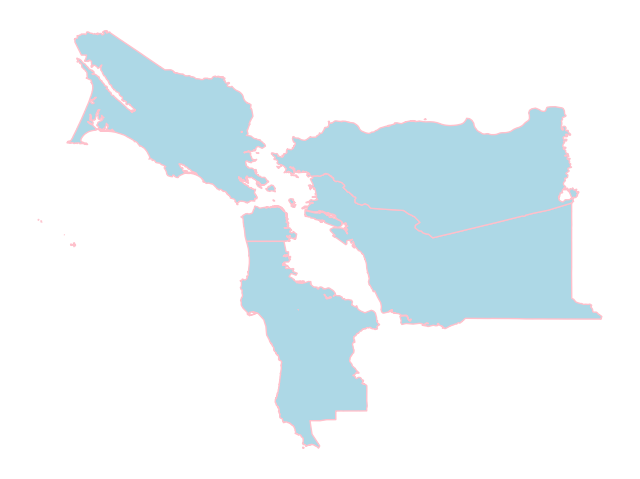

In [5]:
# Bay census county shapefile
bay_area_county_data = pd.read_csv('Bay_Area_County_Polygons_20240416.csv')
counties_of_interest = ['San Mateo', 'San Francisco', 'Marin', 'Alameda', 'Contra Costa']
bay_area_county_data = bay_area_county_data[bay_area_county_data['COUNTY'].isin(counties_of_interest)]
bay_area_county_data['geometry'] = bay_area_county_data['the_geom'].apply(wkt.loads)
bay_area_county_data = gpd.GeoDataFrame(bay_area_county_data, geometry='geometry').drop(columns=['the_geom','OBJECTID'])

fig, ax = plt.subplots(figsize=(8, 8)) 
bay_area_county_data.plot(ax=ax, color='lightblue', edgecolor='pink')
ax.set_axis_off()
plt.show()

In [6]:
# Bay census tract shapefile
url = "https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_06_tract.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall()
gdf = gpd.read_file('tl_2020_06_tract.shp')

# Filter the data to include only specific counties in the San Francisco Bay Area
bay_area_counties = ["075", "081", "001", "013", "041"]  # FIPS codes for SF, San Mateo, Alameda, Contra Costa, Marin
bay_area_tract_data = gdf[gdf["COUNTYFP"].isin(bay_area_counties)]

# Filter out water features (coastline) by ensuring land area is greater than 0
bay_area_tract_data = bay_area_tract_data[bay_area_tract_data['ALAND'] > 0]

# Keep only the essential variables
bay_area_tract_data = bay_area_tract_data[["GEOID", "geometry"]]

bay_area_tract_data.head()

,GEOID,geometry
34,06013392000,"POLYGON ((-122.28449 37.91723, -122.28380 37.9..."
35,06013351200,"POLYGON ((-122.12723 37.87558, -122.12721 37.8..."
104,06013386000,"POLYGON ((-122.32332 37.93110, -122.32272 37.9..."
105,06013354001,"POLYGON ((-122.25030 37.90067, -122.25030 37.9..."
106,06013318000,"POLYGON ((-122.19502 38.03618, -122.19499 38.0..."


In [7]:
# Bay census block group shapefile data
gdf = gpd.read_file('Bay_Area_block_group/cb_2022_06_bg_500k.shp')

# Filter the data to include only specific counties in the San Francisco Bay Area
bay_area_counties = ["075", "081", "001", "013", "041"]  # FIPS codes for SF, San Mateo, Alameda, Contra Costa, Marin
bay_area_block_data = gdf[gdf["COUNTYFP"].isin(bay_area_counties)]

# Filter out water features (coastline) by ensuring land area is greater than 0
bay_area_block_data = bay_area_block_data[bay_area_block_data["ALAND"] > 0]

# Desired variables
bay_area_block_data = bay_area_block_data[["GEOID", "geometry"]]

bay_area_block_data.head()

,GEOID,geometry
3,060759802001,"POLYGON ((-122.51078 37.78206, -122.50748 37.7..."
5,060750105002,"POLYGON ((-122.40049 37.79588, -122.39815 37.7..."
31,060750255021,"POLYGON ((-122.43589 37.73158, -122.43254 37.7..."
38,060750327001,"POLYGON ((-122.49334 37.76477, -122.48691 37.7..."
45,060014506053,"POLYGON ((-121.89571 37.67673, -121.89342 37.6..."


# Data

### Replica OD Data

In [8]:
filename = 'north_bay_replica.csv'
north_bay_mobility = pd.read_csv(filename)

In [9]:
ee.Authenticate()
ee.Initialize()

dataset = ee.ImageCollection('MODIS/006/MOD11A1')

start_date = '2022-01-01'
end_date = '2022-12-31' 
nyc_coords = ee.Geometry.Point(-122.4194, 37.7749)  # SFO coordinates
filtered_dataset = dataset.filterDate(start_date, end_date).filterBounds(nyc_coords)

temperature_image = filtered_dataset.select('LST_Day_1km').mean()

# Define the visualization parameters
vis_params = {
    'min': 13000,
    'max': 16500,
    'palette': ['blue', 'green', 'yellow', 'orange', 'red']
}

# Create a folium map centered on SFO
map_center = [37.7749, -122.4194]
map_zoom = 8
folium_map = folium.Map(location=map_center, zoom_start=map_zoom)

# Add the temperature image to the folium map
map_id = temperature_image.getMapId(vis_params)
folium.TileLayer(
    tiles=map_id['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='Temperature',
    overlay=True,
    control=True
).add_to(folium_map)

folium.LayerControl().add_to(folium_map)  # Add a layer control to the map
display(folium_map)

# Data Analysis

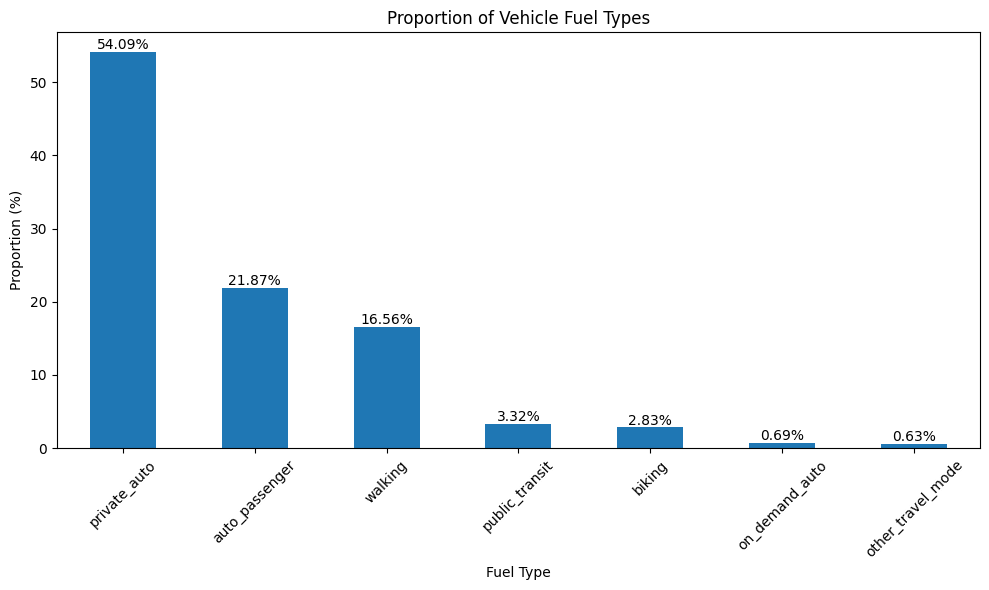

In [10]:
# Count the occurrences of each primary_mode
fuel_type_counts = north_bay_mobility['primary_mode'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
bars = (north_bay_mobility['primary_mode'].value_counts(normalize=True) * 100).plot(kind='bar')
for p in bars.patches:
    bars.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Proportion of Vehicle Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [11]:
print("Number of trips:", north_bay_mobility.shape[0])
print("Number of unique person:", north_bay_mobility['trip_taker_person_id'].nunique())

ev_replica = north_bay_mobility[(north_bay_mobility['primary_mode'] == 'private_auto') & (north_bay_mobility['vehicle_fuel_type'] == 'electric')]
print("Number of EV trips:", ev_replica.shape[0])
print("Number of EV unique person:", ev_replica['trip_taker_person_id'].nunique())

Number of trips: 15384427
Number of unique person: 3901855
Number of EV trips: 471407
Number of EV unique person: 149518


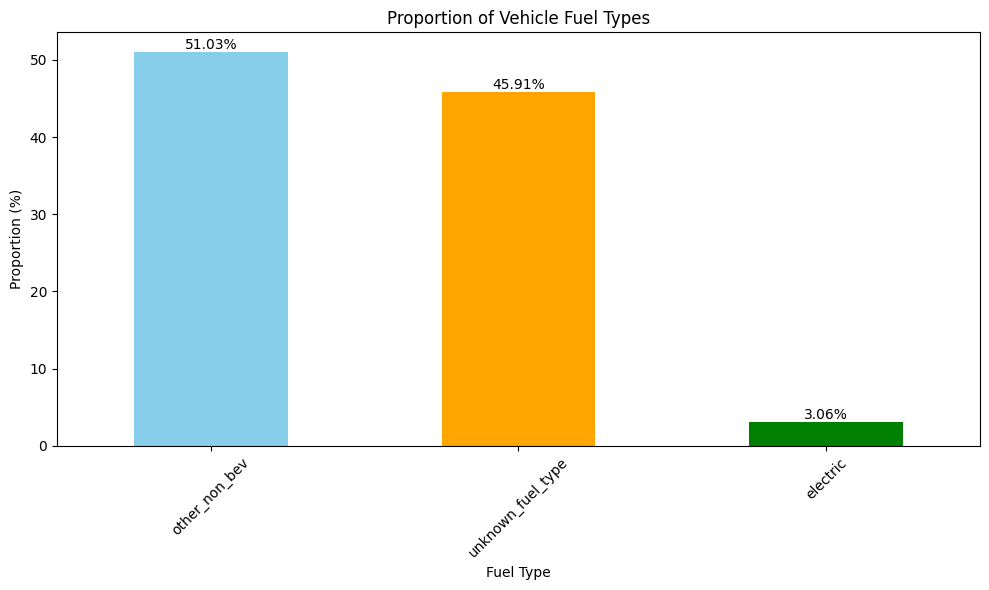

In [12]:
# Count the occurrences of each fuel type
fuel_type_counts = north_bay_mobility['vehicle_fuel_type'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
bars = (north_bay_mobility['vehicle_fuel_type'].value_counts(normalize=True) * 100).plot(kind='bar', color=['skyblue', 'orange', 'green'])
for p in bars.patches:
    bars.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Proportion of Vehicle Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

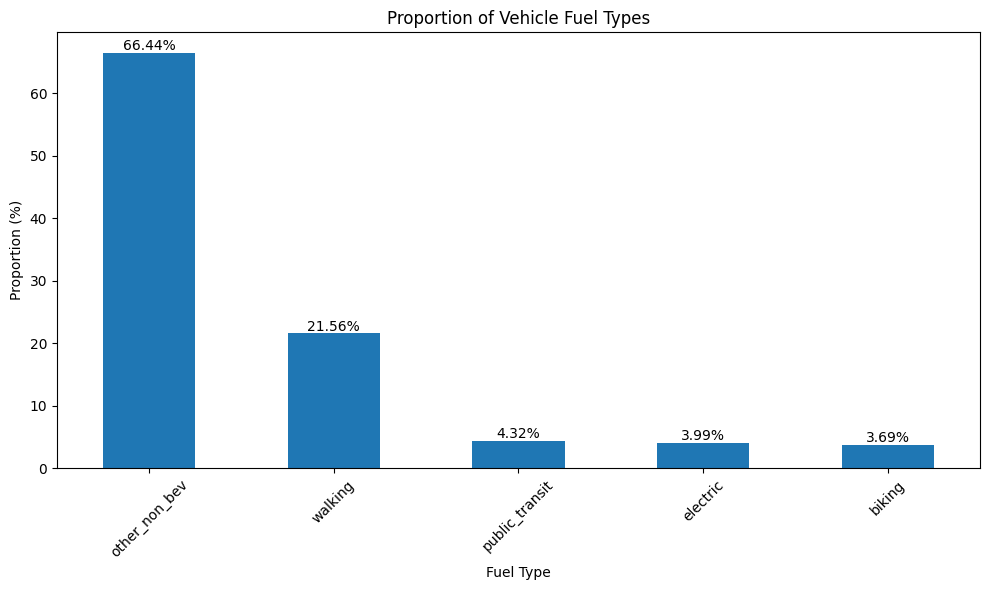

In [13]:
desired_modes = ['walking', 'public_transit', 'biking', 'private_auto']
filtered = north_bay_mobility[north_bay_mobility['primary_mode'].isin(desired_modes)]
# Change 'private_auto' in 'primary_mode' to 'other_non_bev' or 'electric' based on 'vehicle_fuel_type'
filtered.loc[filtered['primary_mode'] == 'private_auto', 'primary_mode'] = filtered['vehicle_fuel_type']

# Count the occurrences of each primary_mode
fuel_type_counts = filtered['primary_mode'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
bars = (filtered['primary_mode'].value_counts(normalize=True) * 100).plot(kind='bar')
for p in bars.patches:
    bars.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Proportion of Vehicle Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [14]:
CO2_EMISSION_FACTORS = {
    'walking': 0,  # Negligible for direct emissions
    'biking': 0,  # Negligible for direct emissions
    'public_transit': 36.5,  # Average of bus and rail
    'electric': 175,  # Assumed national average, adjust based on specific electricity mix
    'other_non_bev': 251  # Average for gasoline cars
}

CO2 = filtered[['trip_start_time', 'trip_end_time', 'trip_duration_minutes',
                'primary_mode','trip_distance_meters',
                    'origin_bgrp_fips_2020','origin_bgrp_lat_2020','origin_bgrp_lng_2020',
                    'destination_bgrp_fips_2020','destination_bgrp_lat_2020','destination_bgrp_lng_2020',
                    'trip_taker_home_bgrp_fips_2020', 'trip_taker_home_bgrp_lat_2020','trip_taker_home_bgrp_lng_2020',
                     'trip_taker_person_id','trip_taker_age','trip_taker_sex','trip_taker_race_ethnicity','trip_taker_education','trip_taker_individual_income']]

# Map primary_mode to CO2 emission factors
CO2['emission_factor'] = CO2['primary_mode'].map(CO2_EMISSION_FACTORS)

# Calculate CO2 emissions in grams
CO2['co2_emissions_grams'] = (CO2['trip_distance_meters'] / 1000) * CO2['emission_factor']
CO2.head()

,trip_start_time,trip_end_time,trip_duration_minutes,primary_mode,trip_distance_meters,origin_bgrp_fips_2020,origin_bgrp_lat_2020,origin_bgrp_lng_2020,destination_bgrp_fips_2020,destination_bgrp_lat_2020,...,trip_taker_home_bgrp_lat_2020,trip_taker_home_bgrp_lng_2020,trip_taker_person_id,trip_taker_age,trip_taker_sex,trip_taker_race_ethnicity,trip_taker_education,trip_taker_individual_income,emission_factor,co2_emissions_grams
1,16:31:12,16:45:38,14,other_non_bev,10159.825469,60014066012,37.7922,-122.2111,60014001001,37.8699,...,37.8699,-122.2336,4476338934782759501,52,female,white_not_hispanic_or_latino,advanced_degree,73052,251.0,2550.116193
2,17:30:00,17:47:18,17,walking,1387.152660,60014001001,37.8699,-122.2336,60014238002,37.8543,...,37.8699,-122.2336,12543989281265016267,47,male,white_not_hispanic_or_latino,advanced_degree,157969,0.0,0.000000
3,16:00:00,16:00:07,0,walking,10.029252,60411043001,38.0789,-122.5075,60411043001,38.0789,...,37.8699,-122.2336,17638473002930754067,55,male,black_not_hispanic_or_latino,high_school,121181,0.0,0.000000
4,06:28:00,06:44:01,16,other_non_bev,2160.013625,60014002001,37.8497,-122.2488,60014001001,37.8699,...,37.8699,-122.2336,5698693218763591625,52,male,white_not_hispanic_or_latino,bachelors_degree,131641,251.0,542.163420
6,18:39:00,18:57:03,18,walking,1344.572154,60014001001,37.8699,-122.2336,60014238002,37.8543,...,37.8699,-122.2336,4625826845185851564,63,female,white_not_hispanic_or_latino,advanced_degree,94781,0.0,0.000000


## Primary Mode

In [15]:
# Filtering data based on 'primary_mode'
CO2_gascar = CO2[CO2['primary_mode'] == 'other_non_bev']
CO2_walk = CO2[CO2['primary_mode'] == 'walking']
CO2_transit = CO2[CO2['primary_mode'] == 'public_transit']
CO2_bike = CO2[CO2['primary_mode'] == 'biking']
CO2_ev = CO2[CO2['primary_mode'] == 'electric']

# CO2_gascar.to_csv('CO2_gascar.csv', index=False)
# CO2_walk.to_csv('CO2_walk.csv', index=False)
# CO2_transit.to_csv('CO2_transit.csv', index=False)
# CO2_bike.to_csv('CO2_bike.csv', index=False)
# CO2_ev.to_csv('CO2_ev.csv', index=False)

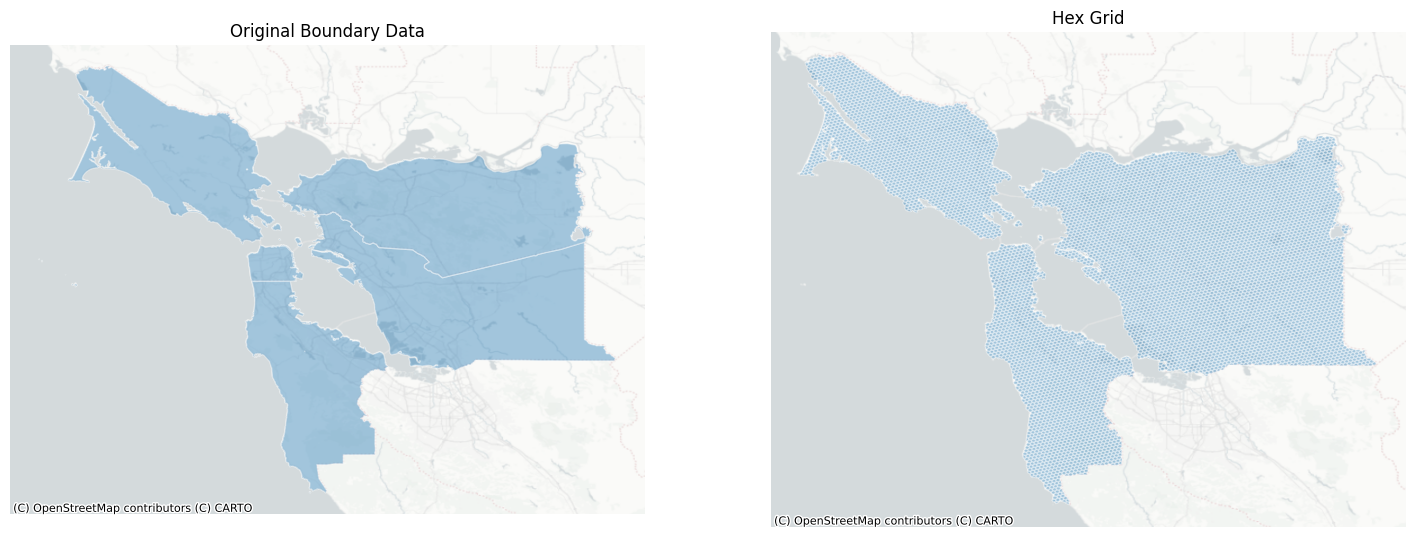

In [16]:
county = bay_area_county_data
county.set_crs('epsg:4326', inplace=True)
hexes = h3fy(county, resolution=8, clip=True)  # 8: edge length of approximately 0.74 km and spans an area of approximately 3 km²

fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

county.plot(ax=axs[0], alpha=0.4, linewidth=1, edgecolor='white')
hexes.plot(ax=axs[1], alpha=0.4, linewidth=1, edgecolor='white')

axs[0].set_title('Original Boundary Data')
axs[1].set_title('Hex Grid')

for i,_ in enumerate(axs):
    cx.add_basemap(
        axs[i],
        crs=hexes.crs.to_string(),
        source=cx.providers.CartoDB.PositronNoLabels)
    axs[i].axis('off')

In [17]:
hexes.shape

(8505, 1)

In [18]:
# Assign to OD straight Lingstring hex

hexes = hexes.reset_index()
CO2['trip_id'] = CO2.index

# Create LineStrings from origin to destination points
CO2['line_geom'] = [LineString([Point(xy1), Point(xy2)]) for xy1, xy2 in zip(
    zip(CO2['origin_bgrp_lng_2020'], CO2['origin_bgrp_lat_2020']),
    zip(CO2['destination_bgrp_lng_2020'], CO2['destination_bgrp_lat_2020'])
)]

# Convert to GeoDataFrame
CO2_geo = gpd.GeoDataFrame(CO2, geometry='line_geom', crs=hexes.crs)

# Perform overlay operation
intersections = gpd.overlay(CO2_geo, hexes[['hex_id', 'geometry']], how='intersection', keep_geom_type=False)

# Calculate emissions per intersected hex
intersections['count'] = intersections.groupby('trip_id')['geometry'].transform('count')
intersections['emissions_per_hex'] = intersections['co2_emissions_grams'] / intersections['count']
total_emissions = intersections.groupby('hex_id')['emissions_per_hex'].sum().reset_index()

# Reset index before merging to avoid ambiguity
hexes = hexes.reset_index(drop=True)
total_emissions = total_emissions.reset_index(drop=True)

# Merge with hexes and replace NaN values with zero
hexes = hexes.merge(total_emissions, on='hex_id', how='left')
hexes['emissions_per_hex'].fillna(0, inplace=True)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
hexes.plot(column='emissions_per_hex', cmap='viridis', legend=True, ax=ax)
ax.set_title('CO2 Emissions per Hex')
plt.show()